![Crisp](img/logo.png)
# <img src="img/weather.svg" alt="icon" width="40"/>  Demand Forecast

[![Open in Colab](https://img.shields.io/badge/Open%20in-Colab-orange?logo=google-colab&style=for-the-badge)](https://colab.research.google.com/github/gocrisp/blueprints/blob/main/notebooks/crisp_demand_forecast.ipynb)
[![Open in Vertex AI](https://img.shields.io/badge/Open%20in-Vertex%20AI%20Workbench-brightgreen?logo=google-cloud&style=for-the-badge)](https://console.cloud.google.com/vertex-ai/notebooks/deploy-notebook?download_url=https://raw.githubusercontent.com/gocrisp/blueprints/main/notebooks/crisp_demand_forecast.ipynb)
[![Open in Databricks](https://img.shields.io/badge/Try-databricks-red?logo=databricks&style=for-the-badge)](https://www.databricks.com/try-databricks)
[![View on GitHub](https://img.shields.io/badge/View%20on-GitHub-lightgrey?logo=github&style=for-the-badge)](https://github.com/gocrisp/blueprints/blob/main/notebooks/crisp_demand_forecast.ipynb)

> To deploy a notebook in Databricks:
> 1. Open your workspace and navigate to the folder where you want to import the notebook.
> 2. Click the triple-dot icon (next to the Share button).
> 3. Select **Import**, then choose **URL** as the import method.
> 4. Paste the notebook's URL, then click **Import** to complete the process.

This notebook demonstrates how to perform a baseline demand forecast on different levels of product and geographic aggregation, so you can optimize inventory management and maximize sales opportunities.

## Set the required environment variables

In [1]:
import os

os.environ["ACCOUNT_ID"] = "123456"

### Run Crisp common

This notebook uses the [crisp_common.ipynb](./crisp_common.ipynb) notebook to load common functions and variables that are used across the Crisp notebooks.

In [ ]:
if not os.path.exists("crisp_common.ipynb"):
    print("Downloading crisp_common.ipynb")
    !wget https://raw.githubusercontent.com/gocrisp/analytics-blueprints-public/main/notebooks/crisp_common.ipynb -O crisp_common.ipynb
else:
    print("crisp_common.ipynb already exists")

%run crisp_common.ipynb

## Import globally-used dependencies

In [3]:
import pandas as pd
import signal
import numpy as np
import matplotlib.pyplot as plt
import holidays
from sklearn.metrics import r2_score, mean_absolute_error
from prophet import Prophet
from matplotlib.ticker import FuncFormatter
import matplotlib.ticker as mtick

### Load the data from BigQuery

We'll load data from the `fact_sales` table, which contains the following key data needed for our analysis: 
1. Time stamp (in weeks to limit daily noise)
2. Product id
3. Product name
4. Product Sub - Category
5. Product Category
6. Store id
7. State
8. Store Latitude
9. Store Longitude

Then, we'll select the following key tables we'll use in this notebook: 
1. Product table
2. Retailer table
3. Sales table

For simplicity and speed, we'll focus on one retailer (e.g., Target) and one category (e.g., Phones & Tablets).


In [4]:
dim_product = "exp_harmonized_retailer_dim_product"
dim_store = "exp_harmonized_retailer_dim_store"
fact_sales = "exp_harmonized_retailer_fact_sales"
fact_inventory = "exp_harmonized_retailer_fact_inventory_store"

retailer = "target"
category = "Phones & Tablets"

### Query historical sales data
We'll gather historical sales by store and product data from the database and create a dataframe.

In [5]:
%%load week_product_store_sales
WITH
  dim_product AS(
  SELECT
    product_id,
    product,
    product_category,
    product_sub_category
  FROM
    `{project}`.`{dataset}`.`{dim_product}`
  WHERE
    retailer = '{retailer}'
  ),
  dim_store AS(
  SELECT
    store_id,
    store_state,
    store_latitude,
    store_longitude
  FROM
    `{project}`.`{dataset}`.`{dim_store}`
  WHERE
    retailer = '{retailer}'
  ),
  fact_sales AS(
  SELECT
    store_id,
    product_id,
    CAST(sales_quantity AS FLOAT64) AS sales_quantity,
    date_key,
    CAST(DATE_TRUNC(CAST(date_key AS DATE), WEEK(MONDAY)) AS DATETIME) AS week_start_date
  FROM
    `{project}`.`{dataset}`.`{fact_sales}`
  WHERE
    retailer = '{retailer}'
  )
SELECT
    --dim_product.product_id,
    dim_product.product,
    dim_product.product_category,
    dim_product.product_sub_category,
    dim_store.store_id,
    dim_store.store_state,
    dim_store.store_latitude,
    dim_store.store_longitude,
    fact_sales.week_start_date AS ds,
    SUM(fact_sales.sales_quantity) AS y
FROM
    fact_sales
INNER JOIN dim_product USING (product_id)
INNER JOIN dim_store USING (store_id)
WHERE 
    dim_product.product_category = '{category}'
GROUP BY 1, 2, 3, 4, 5, 6, 7, 8
ORDER BY dim_store.store_id, dim_product.product, fact_sales.week_start_date

,product,product_category,product_sub_category,store_id,store_state,store_latitude,store_longitude,ds,y
0,LunaTab Horizon,Phones & Tablets,Tablets,3129411238020377,PA,40.195601200,-77.157392500,2021-12-27,4.317150
1,LunaTab Horizon,Phones & Tablets,Tablets,3129411238020377,PA,40.195601200,-77.157392500,2022-01-03,7.984980
2,LunaTab Horizon,Phones & Tablets,Tablets,3129411238020377,PA,40.195601200,-77.157392500,2022-01-10,7.267715
3,LunaTab Horizon,Phones & Tablets,Tablets,3129411238020377,PA,40.195601200,-77.157392500,2022-01-17,6.960311
4,LunaTab Horizon,Phones & Tablets,Tablets,3129411238020377,PA,40.195601200,-77.157392500,2022-01-24,10.897311
...,...,...,...,...,...,...,...,...,...
559315,LunaTech Zenith,Phones & Tablets,Smartphones,993155497649082704,CT,41.376567500,-72.150093000,2024-12-02,16.330843
559316,LunaTech Zenith,Phones & Tablets,Smartphones,993155497649082704,CT,41.376567500,-72.150093000,2024-12-09,22.838480
559317,LunaTech Zenith,Phones & Tablets,Smartphones,993155497649082704,CT,41.376567500,-72.150093000,2024-12-16,20.214911
559318,LunaTech Zenith,Phones & Tablets,Smartphones,993155497649082704,CT,41.376567500,-72.150093000,2024-12-23,35.409597


### Clean and sort data
We'll remove null values and prepare and sort the data. 

In [6]:
# Check if the data is loaded correctly
week_product_store_sales.dropna(inplace=True)  # Clean up any null values

# Sort the DataFrame by the 'ds' column to ensure the dates are in order
week_product_store_sales.sort_values(by="ds", inplace=True)

# Identify the first and last dates
first_date = week_product_store_sales["ds"].iloc[0]
last_date = week_product_store_sales["ds"].iloc[-1]

# Remove all rows with the first and last dates - this is done to avoid any incomplete weeks
week_product_store_sales = week_product_store_sales[
    (week_product_store_sales["ds"] != first_date)
    & (week_product_store_sales["ds"] != last_date)
]

# Display the first few rows to verify the changes
week_product_store_sales

,product,product_category,product_sub_category,store_id,store_state,store_latitude,store_longitude,ds,y
442717,LunaTab Max,Phones & Tablets,Tablets,819832279017916428,NJ,40.012203200,-74.958877500,2022-01-03,0.000000
312367,LunaTech Titan,Phones & Tablets,Smartphones,543200755617401147,NY,40.574808400,-74.166789900,2022-01-03,5.003494
481111,LunaTab Ultra,Phones & Tablets,Tablets,862582753500518315,NY,40.619266100,-73.989155200,2022-01-03,16.174870
387733,LunaTech Pulse,Phones & Tablets,Smartphones,691607882858509103,NJ,40.899191200,-74.039008800,2022-01-03,0.000000
312209,LunaTech Spark,Phones & Tablets,Smartphones,543200755617401147,NY,40.574808400,-74.166789900,2022-01-03,3.072032
...,...,...,...,...,...,...,...,...,...
398000,LunaTech Verse,Phones & Tablets,Tablets,707197746439044884,NY,40.623943500,-74.139065100,2024-12-23,4.047786
473682,LunaTech Titan,Phones & Tablets,Smartphones,853304317222328464,NY,40.746944000,-73.883664500,2024-12-23,0.000000
9478,LunaTech Zenith,Phones & Tablets,Smartphones,6888497719442273,PA,40.321597000,-75.133341000,2024-12-23,53.521864
139196,LunaTab Horizon,Phones & Tablets,Tablets,238637323229318363,CT,41.783909100,-72.747952200,2024-12-23,20.266653


### Define functions for forecasting
We will define the following functions that will be used to forecast the sales data for a given product and store:

    1. fill_missing_weeks: This function will fill in the missing weeks in the sales data with zero values.
    2. prophet_forecast: This function will forecast the sales data using the Prophet model (an open-source time-series forecasting model).
    3. run_forecast: This function will run the entire forecasting process for a given product and store.
    4. plot_sales_forecast: This function provides a standard way to plot the components of the sales forecast.

In [7]:
def fill_missing_weeks(df: pd.DataFrame, last_day: pd.Timestamp = None) -> pd.DataFrame:
    """
    Fill missing weekly dates in the DataFrame with zeros.

    Parameters:
    df (pd.DataFrame): DataFrame with columns ['ds', 'y'] where 'ds' is the date and 'y' is the target variable.
    last_day (pd.Timestamp): Last day of the date range. If provided, the date range will be extended to this date.

    Returns:
    pd.DataFrame: DataFrame with missing weekly dates filled with zeros.
    """
    # Ensure 'ds' column is in datetime format
    df["ds"] = pd.to_datetime(df["ds"])

    # Find the minimum and maximum dates
    min_date = df["ds"].min()
    max_date = df["ds"].max()

    # If last_day is provided and is greater than max_date, extend the max_date to last_day
    if last_day is not None and last_day > max_date:
        max_date = last_day

    # Create a complete date range with weekly frequency starting on Monday
    complete_date_range = pd.date_range(start=min_date, end=max_date, freq="W-MON")

    # Reindex the DataFrame to the complete date range, filling missing values with zeros
    df = df.set_index("ds").reindex(complete_date_range).fillna(0).reset_index()
    df.columns = ["ds", "y"]

    return df

In [8]:
def prophet_forecast(
    df: pd.DataFrame, periods: int, params: dict, cap: float = 1.5, floor: float = 0.5
) -> pd.DataFrame:
    """
    Run forecast using the Prophet model on the provided dataframe, assuming weekly data.

    Parameters:
    df (pd.DataFeame): DataFrame with columns ['ds', 'y'] where 'ds' is the date and 'y' is the target variable.
    periods (int): Number of periods to forecast into the future.
    params (dict): Hyperparameters for the Prophet model.
    cap (float): Multiplier on max Sales to be used as maximum value that the target variable can take.
    floor (float): Multiplier on min Sale to be used as minimum value that the target variable can take.

    Returns:
    forecast (pd.DataFrame): DataFrame with columns ['ds', 'yhat', 'yhat_lower', 'yhat_upper'] with the forecasted values.
    yhat is the predicted value, yhat_lower is the lower bound of the prediction interval, and yhat_upper is the upper bound of the prediction interval.
    """
    df = df.copy()

    # Set the cap and floor values for logistic regression
    cap_value = (
        cap * df["y"].tail(52).mean() + 1
    )  # Can be modified according to the data. # Add 1 to avoid errors on logistic forecast
    floor_value = floor * df["y"].tail(52).mean()

    df["cap"] = cap_value
    df["floor"] = floor_value

    # Train the model
    model = Prophet(
        **params,
        holidays=holidays_df,
    )

    # Fit the model to the data
    model.fit(df)

    # Create dataframe with future dates
    future = model.make_future_dataframe(
        periods=periods, freq="W-MON"
    )  # Set Monday as start of the week
    future["cap"] = cap_value
    future["floor"] = floor_value

    forecast = model.predict(future)

    # Set any negative forecasted values to zero - If using linear growth
    forecast["yhat"] = forecast["yhat"].apply(lambda x: max(x, 0))
    forecast["yhat_lower"] = forecast["yhat_lower"].apply(lambda x: max(x, 0))
    forecast["yhat_upper"] = forecast["yhat_upper"].apply(lambda x: max(x, 0))

    return forecast

In [9]:
# The function below is set to stop execution of very long running tieseries forecasts
# Define the timeout handler
class TimeoutException(Exception):
    pass


def timeout_handler(signum, frame):
    raise TimeoutException("Function timed out")

In [10]:
def run_forecast(
    df: pd.DataFrame,
    periods: int,
    params: dict = {},
    last_day: pd.Timestamp = None,
    metrics: bool = False,
    cap: float = 1.5,
    floor: float = 0.5,
) -> pd.DataFrame:
    """
    Run forecast on the provided dataframe and calculate validation metrics.

    Parameters:
    df (pd.DataFrame): DataFrame with columns ['ds', 'y'] where 'ds' is the date and 'y' is the target variable.
    periods (int): Number of periods to forecast into the future.
    params (dict): Hyperparameters for the Prophet model.
    last_day (pd.Timestamp): Last day of the date range. If provided, the date range will be extended to this date.
    metrics (bool): If True, calculate validation metrics on the test set.
    cap (float): Multiplier on max Sales to be used as maximum value that the target variable can take.
    floor (float): Multiplier on min Sale to be used as minimum value that the target variable can take.

    Returns:
    pd.DataFrame: DataFrame with forecasted values and validation metrics. Columns include:
                  - 'ds': Date
                  - 'yhat': Predicted value
                  - 'yhat_lower': Lower bound of the prediction interval
                  - 'yhat_upper': Upper bound of the prediction interval
                  - 'y': Actual value
                  - 'holiday and seasoanlity components'
                  - 'mae': Mean Absolute Error on the test set
                  - 'r2': R^2 score on the test set
    """

    # Fill missing weeks in the dataset
    df = fill_missing_weeks(df, last_day=last_day)

    # If in the last 52 weeks the timeseries has no sales, return empty dataframe
    if df["y"].tail(52).sum() <= 0:
        return pd.DataFrame()

    # Set the timeout handler
    signal.signal(signal.SIGALRM, timeout_handler)
    signal.alarm(5)  # Set the timeout to 5 seconds

    try:
        forecast = prophet_forecast(df, periods, params, cap, floor)
    except TimeoutException:
        print("Main forecasting timed out, skipping this time series.")
        return pd.DataFrame()
    finally:
        signal.alarm(0)  # Disable the alarm

    # Merge actual sales with the forecast
    forecast = forecast.merge(df[["ds", "y"]], on="ds", how="left")

    if not metrics:
        return forecast

    if df.shape[0] < 2:
        forecast["mae"] = np.nan
        forecast["r2"] = np.nan
        return forecast

    # If metrics set to True, run a validation model to obtain validation metrics
    train_size = int(0.8 * len(df))
    train_df = df[:train_size]
    test_df = df[train_size:]
    test_period = len(test_df)

    # Set the timeout handler for the test forecast
    signal.signal(signal.SIGALRM, timeout_handler)
    signal.alarm(60)  # Set the timeout to 60 seconds

    try:
        # Run the model on the training data
        test_forecast = prophet_forecast(train_df, test_period, params=params)
    except TimeoutException:
        print("Test forecasting timed out, skipping this time series.")
        forecast["mae"] = np.nan
        forecast["r2"] = np.nan
        return forecast
    finally:
        signal.alarm(0)  # Disable the alarm

    # Calculate MAE and R^2 on the test set
    mae = mean_absolute_error(test_df["y"], test_forecast["yhat"][-test_period:])
    r2 = r2_score(test_df["y"], test_forecast["yhat"][-test_period:])

    # Append validation metrics to the forecast dataframe
    forecast["mae"] = mae
    forecast["r2"] = r2

    return forecast

In [11]:
def plot_sales_forecast(data, path="forecast_plot.png"):
    """
    Plot the sales forecast for each product.

    Parameters:
    data (pd.DataFrame): DataFrame with columns ['ds', 'y', 'yhat', 'yhat_lower', 'yhat_upper', 'product_scope', 'trend', 'yearly', 'holidays'].
    path (str): Path to save the plot.

    Returns:
    None
    """

    product_scopes = data["product_scope"].unique()
    num_scopes = len(product_scopes)

    plt.figure(figsize=(15 * num_scopes, 18))

    for i, scope in enumerate(product_scopes):
        scope_data = data[data["product_scope"] == scope]
        product = scope_data["product_scope"].iloc[0]

        # Plot actual sales
        plt.subplot(4, num_scopes, i + 1)
        plt.plot(
            scope_data["ds"],
            scope_data["y"],
            label="Actual",
            color="black",
            linestyle="-",
            marker="o",
            markersize=6,
            linewidth=1,
        )
        plt.plot(
            scope_data["ds"],
            scope_data["yhat"],
            label="Forecast",
            color="blue",
            linestyle="-",
            marker="o",
            markersize=3,
            linewidth=1.5,
        )
        plt.fill_between(
            scope_data["ds"],
            scope_data["yhat_lower"],
            scope_data["yhat_upper"],
            color="skyblue",
            alpha=0.4,
            label="Forecast Range",
        )
        plt.title(f"Product {product} Sales Forecast", fontsize=16, fontweight="bold")
        plt.xlabel("Date", fontsize=14)
        plt.ylabel("Sales Quantity", fontsize=14)
        plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{x:,.0f}"))
        plt.grid(True, linestyle="--", alpha=0.6)
        plt.legend(loc="upper left", fontsize=12)

        # Plot trend contribution
        plt.subplot(4, num_scopes, num_scopes + i + 1)
        plt.plot(
            scope_data["ds"],
            scope_data["trend"],
            label="Trend",
            color="green",
            linestyle="-",
            marker="o",
            markersize=6,
            linewidth=1,
        )
        plt.title(
            f"Product {product} Trend Contribution", fontsize=16, fontweight="bold"
        )
        plt.xlabel("Date", fontsize=14)
        plt.ylabel("Trend", fontsize=14)
        plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{x:,.0f}"))
        plt.grid(True, linestyle="--", alpha=0.6)
        plt.legend(loc="upper left", fontsize=12)

        # Plot seasonality contribution
        if "yearly" in scope_data.columns:
            plt.subplot(4, num_scopes, 2 * num_scopes + i + 1)
            plt.plot(
                scope_data["ds"],
                scope_data["yearly"],
                label="Seasonality",
                color="orange",
                linestyle="-",
                marker="o",
                markersize=6,
                linewidth=1,
            )
            plt.title(f"Product {product} Seasonality", fontsize=16, fontweight="bold")
            plt.xlabel("Date", fontsize=14)
            plt.ylabel("Seasonality", fontsize=14)
            plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
            plt.grid(True, linestyle="--", alpha=0.6)
            plt.legend(loc="upper left", fontsize=12)

        # Plot holiday contribution
        if "holidays" in scope_data.columns:
            plt.subplot(4, num_scopes, 3 * num_scopes + i + 1)
            plt.plot(
                scope_data["ds"],
                scope_data["holidays"],
                label="Holidays",
                color="red",
                linestyle="-",
                marker="o",
                markersize=6,
                linewidth=1,
            )
            plt.title(
                f"Product {product} Holiday Contribution",
                fontsize=16,
                fontweight="bold",
            )
            plt.xlabel("Date", fontsize=14)
            plt.ylabel("Holidays", fontsize=14)
            plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
            plt.grid(True, linestyle="--", alpha=0.6)
            plt.legend(loc="upper left", fontsize=12)

    plt.tight_layout()
    plt.savefig(path)
    plt.show()

## Define holidays for the forecast
Holidays will be a key component of our forecast, so we will create a holidays dataframe to use, which focuses on US national holidays.

In [12]:
# Create US holidays object
us_holidays = holidays.US(
    years=[2021, 2022, 2023, 2024, 2025, 2026]
)  # Add more years if needed

# Convert the holidays to a DataFrame
holidays_df = pd.DataFrame(us_holidays.items(), columns=["ds", "holiday"])

# Convert the date column to Monday of the week to align with the week_start_date definition on sales data
holidays_df["ds"] = holidays_df["ds"].apply(
    lambda x: x - pd.DateOffset(days=x.weekday())
)

# Add week before and week after holidays as a parameter - The week leading and lagging the holiday can have an impact on sales.
holidays_df["lower_window"] = -7
holidays_df["upper_window"] = 7

## Section 1: Category analysis - Long term forecast
In this section, we will perform a long range forecast (one full year ahead) for an aggregated set of geographic regions. Long-range forecasts can help inform important strategic goals and plans, such as capacity and logistics planning, finance planning, resource allocation, and sales target setting.

We will also break projected sales out into three components: underlying trends, seasonality, and holiday impacts.

Then, we will focus our forecast using the following scope:
- Product : Total Category 
- Geo: Total US + States 
- Forecast Range: One full year ahead.

### Analyze total US sales
We will first run our model on the total category for all of the US and evaluate the results.

In [13]:
# Aggregate data set on total US, total category level
us_category_sales = (
    week_product_store_sales.groupby("ds").agg({"y": "sum"}).reset_index()
)

# Visualize data for validation
us_category_sales

,ds,y
0,2022-01-03,34621.686807
1,2022-01-10,34958.659835
2,2022-01-17,34922.566191
3,2022-01-24,36062.058448
4,2022-01-31,36648.546732
...,...,...
151,2024-11-25,64950.875318
152,2024-12-02,50775.971835
153,2024-12-09,49893.399540
154,2024-12-16,48829.449360


In [14]:
# Set the parameters for the Prophet model:
params = {
    "seasonality_mode": "multiplicative",
    "growth": "linear",
    "changepoint_prior_scale": 0.015,
}

Now that the parameters are set, we will perform the forecast.

In [ ]:
# Find forecast periods needed for a full year ahead prediction in weeks
final_date = pd.to_datetime("2026-01-01")  # Set the final date for the forecast
latest_date = us_category_sales["ds"].max()  # Find the latest date in the data
periods = (final_date - latest_date).days // 7

# Run the forecast on the category aggregated data
us_category_forecast = run_forecast(
    us_category_sales,
    periods=periods,
    params=params,
    metrics=True,
    cap=2.0,
    floor=0.2,
    last_day=latest_date,
)

# Validate the forecast
us_category_forecast

We will save the forecast as a csv file.

In [16]:
# Save the forecast as a csv file
us_category_forecast.to_csv("us_category_forecast.csv", index=False)

We will now visualize the forecast and its components.

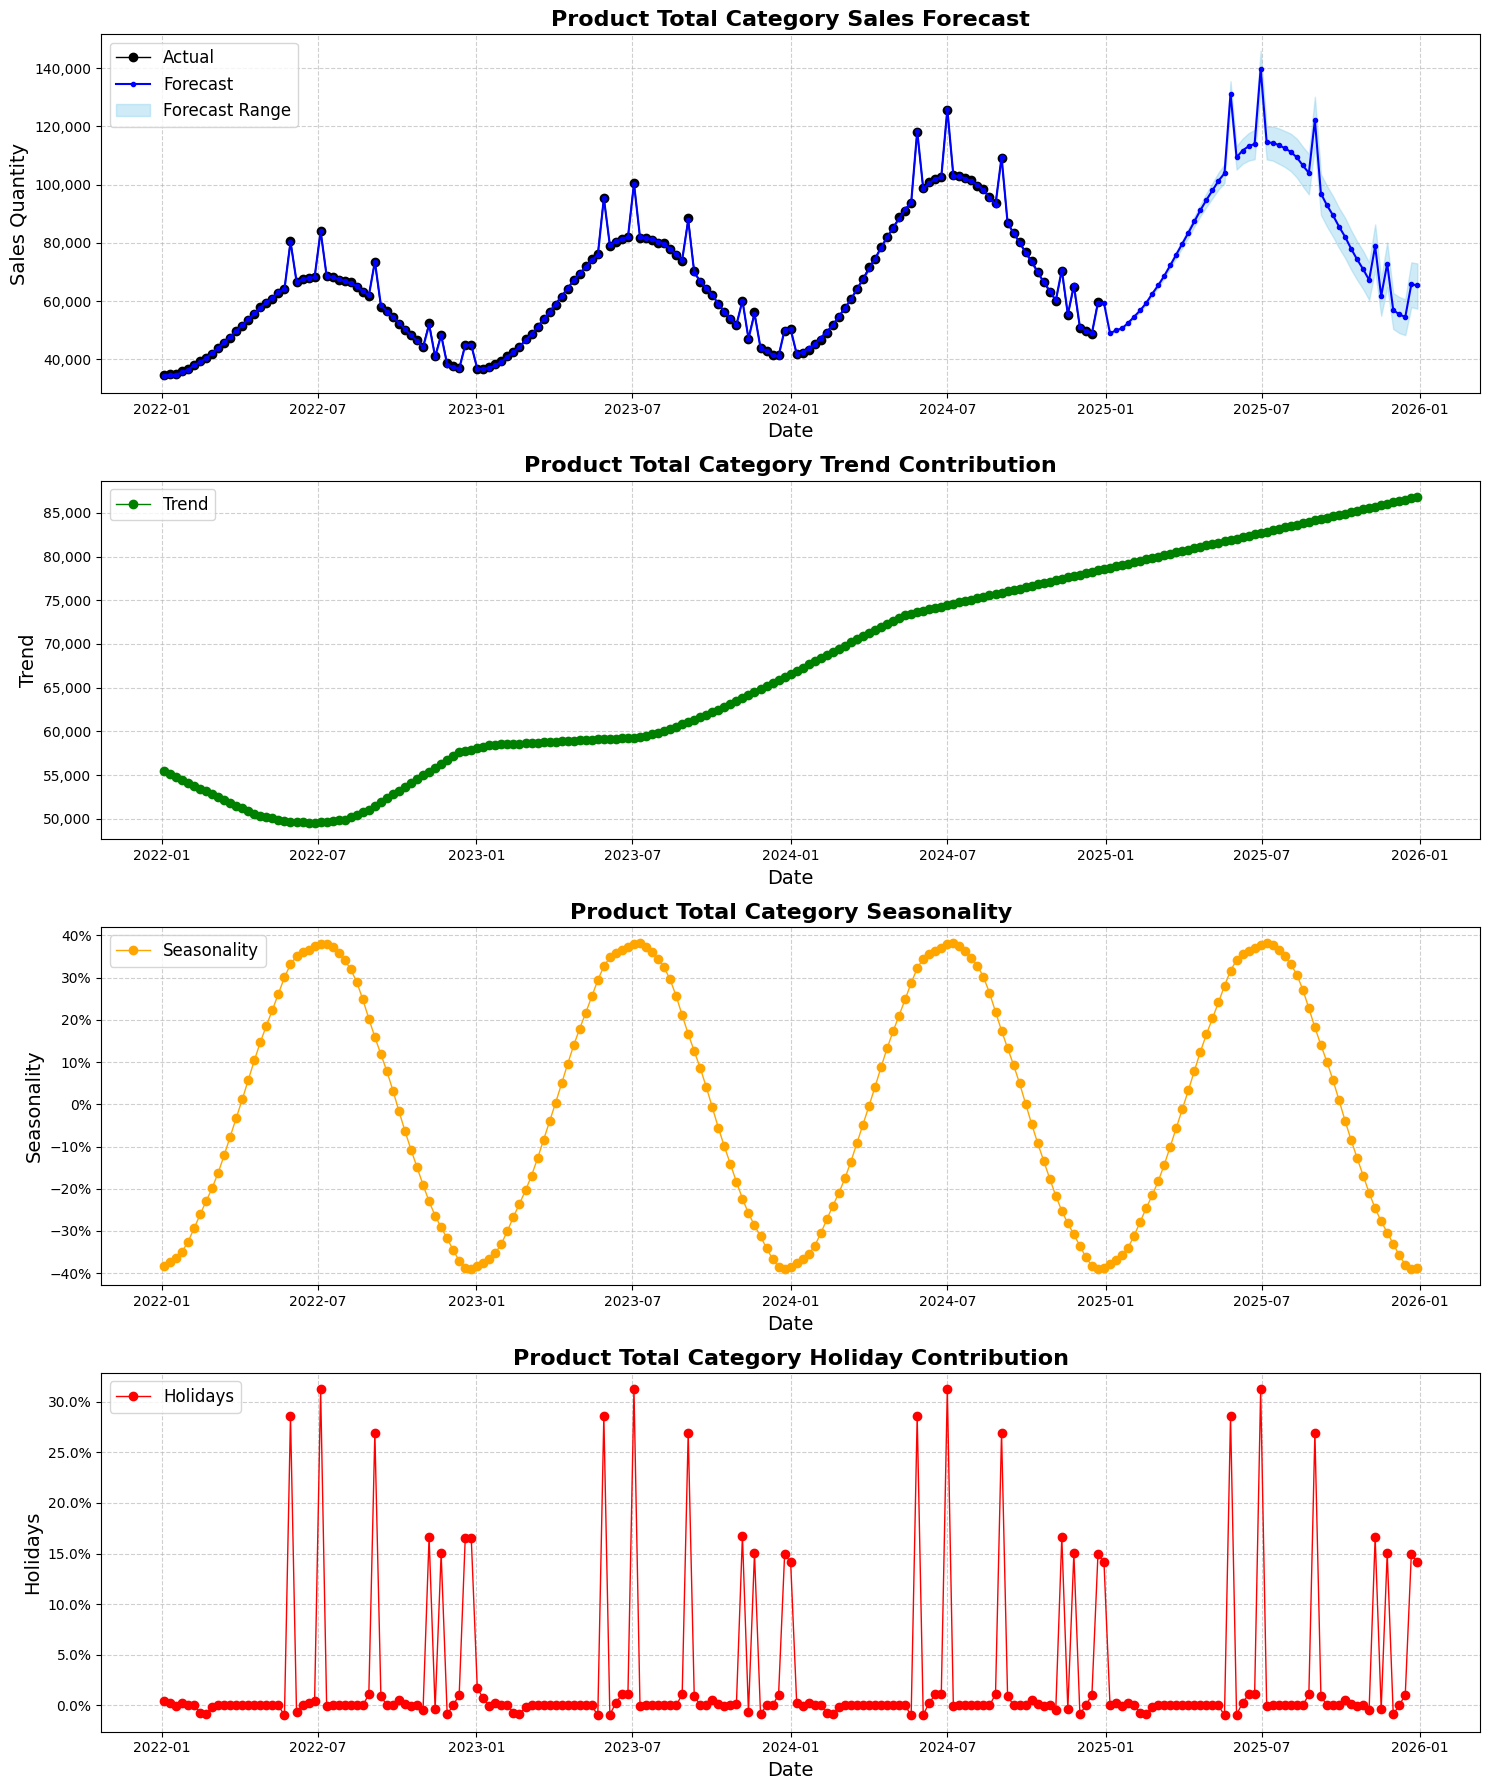

In [17]:
# Add column to the forecast dataframe to identify the product scope (for plotting purposes).
us_category_forecast["product_scope"] = "Total Category"
plot_sales_forecast(us_category_forecast, path="us_category_forecast.png")

### Forecast at the state level

We will now forecast sales for all states for the full category and evaluate the results.

In [ ]:
# Run the forecast on the category aggregated data by state
state_category_sales = (
    week_product_store_sales.groupby(["store_state", "ds"])
    .agg({"y": "sum"})
    .reset_index()
)

# Run the forecast on the category aggregated data by state
state_category_forecast = (
    state_category_sales.groupby("store_state")
    .apply(
        run_forecast,
        periods=periods,
        params=params,
        cap=2.0,
        floor=0.2,
        last_day=latest_date,
        metrics=False,
        include_groups=False,
    )
    .reset_index(level=[0], drop=False)
)

# Validate the output
state_category_forecast

We will then visualize key metrics of state-level sales in a table:

In [19]:
# Group by and pivot tables to analyze expected sales

# Create a year column to pivot the data
state_category_forecast["year"] = state_category_forecast["ds"].dt.year

# Identify the last date where actuals are not NaN
last_actual_date = state_category_forecast["ds"][
    state_category_forecast["y"].notna()
].max()

# Create the 'actuals_forecast' column
state_category_forecast["actuals_forecast"] = np.where(
    state_category_forecast["ds"] <= last_actual_date,
    state_category_forecast["y"],
    state_category_forecast["yhat"],
)

# Group by year and state, then sum the sales
yearly_sales = (
    state_category_forecast.groupby(["year", "store_state"])["actuals_forecast"]
    .sum()
    .reset_index()
)

# Pivot the table to have years as columns and states as rows
sales_pivot = yearly_sales.pivot(
    index="store_state", columns="year", values="actuals_forecast"
).reset_index()

# Calculate the year-over-year absolute change
sales_pivot["2025_vs_2024_abs_change"] = sales_pivot[2025] - sales_pivot[2024]

# Calculate the year-over-year percentage change
sales_pivot["2025_vs_2024_pct_change"] = (
    sales_pivot["2025_vs_2024_abs_change"] / sales_pivot[2024]
) * 100

# Sort by the absolute change from 2025 to 2024
sales_pivot = sales_pivot.sort_values(by=2024, ascending=False)

# Display the resulting table
sales_pivot

year,store_state,2022,2023,2024,2025,2025_vs_2024_abs_change,2025_vs_2024_pct_change
2,NY,1.144534e+06,1.327198e+06,1.651099e+06,1.875294e+06,224195.059754,13.578539
3,PA,6.948600e+05,8.080525e+05,1.013635e+06,1.171874e+06,158238.753051,15.611012
1,NJ,6.171284e+05,7.084589e+05,8.783871e+05,1.026157e+06,147769.461404,16.822818
0,CT,3.267152e+05,3.802136e+05,4.738003e+05,5.639460e+05,90145.777783,19.026114


Save the state-level forecast as a csv file.

In [20]:
# save the table as a csv file
sales_pivot.to_csv("state_pivot.csv", index=False)
state_category_forecast.to_csv("state_category_forecast.csv", index=False)

We will display the forecast graphically (colors represent the absolute demand).

In [21]:
import requests
import folium

url = "https://raw.githubusercontent.com/python-visualization/folium-example-data/main/us_states.json"
response = requests.get(url)

with open("us-states.json", "wb") as f:
    f.write(response.content)

from folium import Choropleth, Tooltip
import json

# Load US states geojson file
with open("us-states.json") as f:
    us_states = json.load(f)
# Create a folium map centered on the US

# Calculate the average latitude and longitude of the stores
average_latitude = week_product_store_sales["store_latitude"].mean()
average_longitude = week_product_store_sales["store_longitude"].mean()

# Create a folium map centered on the average latitude and longitude
m = folium.Map(location=[average_latitude, average_longitude], zoom_start=6)

# Add a Choropleth layer to the map
Choropleth(
    geo_data=us_states,
    name="choropleth",
    data=sales_pivot,
    columns=["store_state", "2025_vs_2024_abs_change"],
    key_on="feature.id",
    fill_color="YlGnBu",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="2025 vs 2024 Sales Volume",
).add_to(m)


# Function to create tooltip text
def create_tooltip(row):
    return (
        f"State: {row['store_state']}<br>"
        f"2024 Sales: {row[2024]:,.0f}<br>"
        f"2025 Sales: {row[2025]:,.0f}<br>"
        f"2025 vs 2024 Sales Delta: {row['2025_vs_2024_abs_change']:,.0f}<br>"
        f"2025 vs 2024 Pct Change: {row['2025_vs_2024_pct_change']:.2f}%"
    )


# Add tooltips to each state
for feature in us_states["features"]:
    state_name = feature["id"]
    row = sales_pivot[sales_pivot["store_state"] == state_name]
    if not row.empty:
        tooltip_text = create_tooltip(row.iloc[0])
        folium.GeoJson(
            feature,
            style_function=lambda x: {
                "fillColor": "#ffffff00",
                "color": "#00000000",
                "weight": 0,
            },
            tooltip=Tooltip(tooltip_text),
        ).add_to(m)


m

In [22]:
# Save the map as an html file
m.save("us_sales_map.html")

## Section 2: Sub-category analysis - Long term forecast
In this section, we will perform a long range forecast (one full year ahead) for each sub-category in the category. These types of forecasts help you identify overall drivers of growth and decline in the category. We will also be able to identify products that are more seasonal than others and have more influence from holidays.

We will focus our forecast using the following scope:
- Product : sub-category within category 
- Geo: Total US 
- Forecast Range: One full year ahead.

### Analyze total US sales by subcategory

In [23]:
# Aggregate sales data by brand and total country
sub_category_sales = (
    week_product_store_sales.groupby(["product_sub_category", "ds"])
    .agg({"y": "sum"})
    .reset_index()
)

# Check data for validation
sub_category_sales

,product_sub_category,ds,y
0,Smartphones,2022-01-03,12955.353100
1,Smartphones,2022-01-10,13656.248710
2,Smartphones,2022-01-17,13605.366721
3,Smartphones,2022-01-24,14502.113126
4,Smartphones,2022-01-31,15210.526719
...,...,...,...
307,Tablets,2024-11-25,17550.154217
308,Tablets,2024-12-02,13355.879018
309,Tablets,2024-12-09,13567.107465
310,Tablets,2024-12-16,13341.215130


In [ ]:
# Run the forecast on the sub-category aggregated data
sub_category_forecast = (
    sub_category_sales.groupby("product_sub_category")
    .apply(
        run_forecast,
        periods=periods,
        params=params,
        cap=2.0,
        floor=0.2,
        last_day=latest_date,
        metrics=False,
        include_groups=False,
    )
    .reset_index(level=[0], drop=False)
)

# Validate the forecast
sub_category_forecast

We will now visualize the data to understand breakouts in trend, seasonality and holidays.

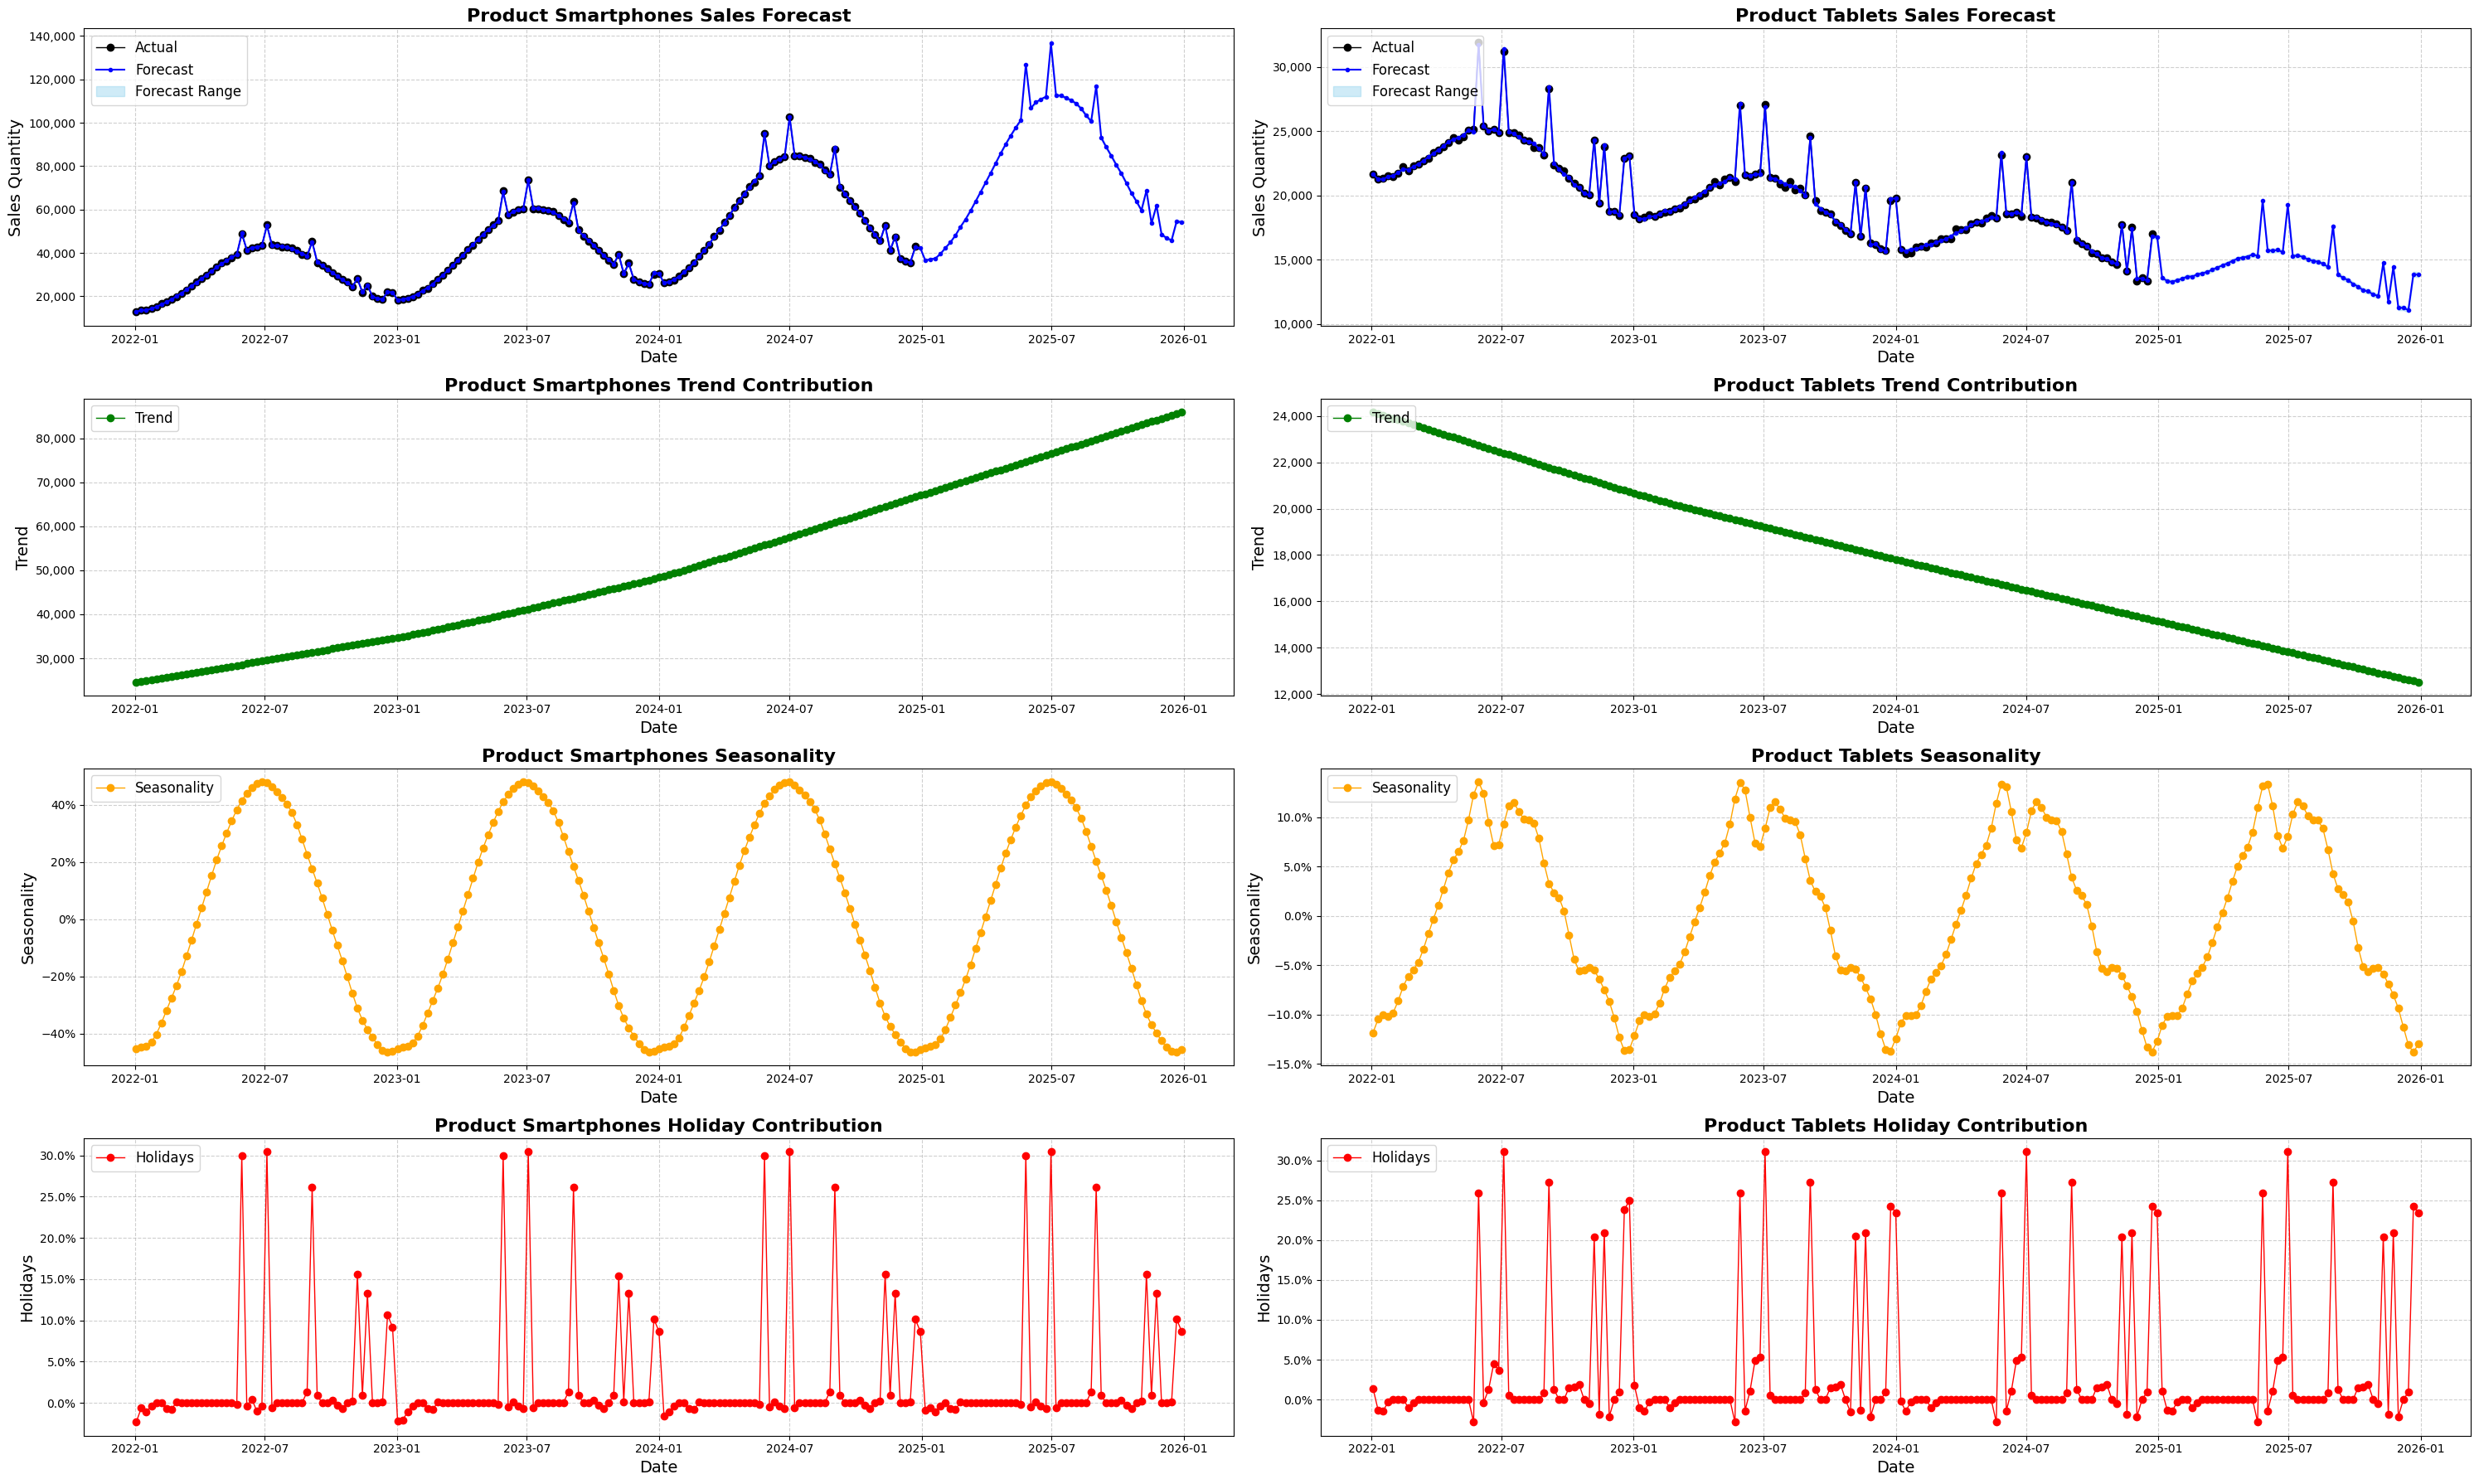

In [25]:
# Add product scope for plotting
sub_category_forecast["product_scope"] = sub_category_forecast["product_sub_category"]

plot_sales_forecast(sub_category_forecast, path="sub_category_forecast.png")

Similar to the previous section, we will identify sales trends for the sub-categories.

In [26]:
sub_category_forecast["year"] = sub_category_forecast["ds"].dt.year

# Identify the last date where actuals are not NaN
last_actual_date = sub_category_forecast["ds"][sub_category_forecast["y"].notna()].max()

# Create the 'actuals_forecast' column
sub_category_forecast["actuals_forecast"] = np.where(
    sub_category_forecast["ds"] <= last_actual_date,
    sub_category_forecast["y"],
    sub_category_forecast["yhat"],
)

# Group by year, state, and brand category. Then, sum the sales.
yearly_sales = (
    sub_category_forecast.groupby(["year", "product_sub_category"])["actuals_forecast"]
    .sum()
    .reset_index()
)

# Pivot the table to have years as columns and states as rows
sub_category_pivot = yearly_sales.pivot_table(
    index=["product_sub_category"], columns="year", values="actuals_forecast"
).reset_index()

# Calculate the year-over-year absolute change
sub_category_pivot["2025_vs_2024_abs_change"] = (
    sub_category_pivot[2025] - sub_category_pivot[2024]
)

# Calculate the year-over-year percentage change
sub_category_pivot["2025_vs_2024_pct_change"] = (
    sub_category_pivot["2025_vs_2024_abs_change"] / sub_category_pivot[2024]
) * 100

# Sort by the absolute 2024 volume
sub_category_pivot = sub_category_pivot.sort_values(by=2024, ascending=False)

sub_category_pivot

year,product_sub_category,2022,2023,2024,2025,2025_vs_2024_abs_change,2025_vs_2024_pct_change
0,Smartphones,1.576665e+06,2.193674e+06,3.110990e+06,4.092118e+06,981128.315658,31.53750
1,Tablets,1.206572e+06,1.030249e+06,9.047234e+05,7.425690e+05,-162154.393980,-17.92309


In [27]:
# Save the table as a csv file
sub_category_pivot.to_csv("brand_category_pivot.csv", index=False)

## Section 3: Store / product analysis - next four weeks forecast
In this section, we will perform a short-term forecast (four weeks ahead) for each product/store combination. These types of forecasts can help you with more tactical planning, such as shipment plans and inventory management.

We will focus our forecast using the following scope:
- Product : Product level 
- Geo: Store 
- Forecast Range: 4 weeks ahead

### Store level

To simplify the analysis, we will limit it to a set of ten stores. This can be scaled up to meet your needs (given enough computing resources). We will define a random set of stores to run the forecast.

In [28]:
# Select a random sample of 10 store combinations
sampled_combinations = (
    week_product_store_sales[["store_id"]]
    .drop_duplicates()
    .sample(n=10, random_state=10)
)

# Filter the original dataframe to include only the sampled combinations
store_product_data = week_product_store_sales.merge(
    sampled_combinations, on=["store_id"]
)[["product", "store_id", "ds", "y", "store_latitude", "store_longitude"]]


store_product_data

,product,store_id,ds,y,store_latitude,store_longitude
0,LunaTech Edge,275635318942753638,2022-01-03,10.962306,40.757304400,-73.835146000
1,LunaTech Spark,233609947931059771,2022-01-03,3.021268,40.687544800,-73.406050000
2,LunaTech Axis,275635318942753638,2022-01-03,17.353727,40.757304400,-73.835146000
3,LunaTech Nova,890301629616668391,2022-01-03,5.744116,40.795531800,-73.931036500
4,LunaTech Helios,275635318942753638,2022-01-03,22.173381,40.757304400,-73.835146000
...,...,...,...,...,...,...
31195,LunaTech Verse,535005083459727284,2024-12-23,10.344723,40.641571000,-74.422363200
31196,LunaTech Axis,828562629515749746,2024-12-23,9.830836,40.607669100,-73.959576200
31197,LunaTab X,828562629515749746,2024-12-23,8.140165,40.607669100,-73.959576200
31198,LunaTech Slate,535005083459727284,2024-12-23,9.273644,40.641571000,-74.422363200


Next, we will run the forecast for each individual store/product combination.

In [ ]:
store_product_forecast = (
    store_product_data.groupby(
        ["product", "store_id", "store_latitude", "store_longitude"]
    )
    .apply(
        run_forecast,
        params=params,
        periods=4,
        cap=2.0,
        floor=0.2,
        last_day=latest_date,
        metrics=False,
        include_groups=False,
    )
    .reset_index(level=[0, 1, 2, 3], drop=False)
)

We will merge the original sales with the forecasted data.

In [30]:
# Validate the output of the forecast
store_product_forecast

,product,store_id,store_latitude,store_longitude,ds,trend,cap,yhat_lower,yhat_upper,trend_lower,...,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat,y
0,LunaTab Horizon,62290197321759762,40.808414000,-73.946204000,2022-01-03,6.622437,12.010707,3.331520,8.281070,6.622437,...,-0.107319,-0.107319,-0.108875,-0.108875,-0.108875,0.0,0.0,0.0,5.911727,7.114697
1,LunaTab Horizon,62290197321759762,40.808414000,-73.946204000,2022-01-10,6.614063,12.010707,4.915573,10.200966,6.614063,...,0.126831,0.126831,0.135815,0.135815,0.135815,0.0,0.0,0.0,7.452934,3.322247
2,LunaTab Horizon,62290197321759762,40.808414000,-73.946204000,2022-01-17,6.605690,12.010707,6.902419,11.730042,6.605690,...,0.411325,0.411325,0.384197,0.384197,0.384197,0.0,0.0,0.0,9.322777,9.754264
3,LunaTab Horizon,62290197321759762,40.808414000,-73.946204000,2022-01-24,6.597316,12.010707,7.201361,11.955685,6.597316,...,0.448650,0.448650,0.437401,0.437401,0.437401,0.0,0.0,0.0,9.557200,8.247715
4,LunaTab Horizon,62290197321759762,40.808414000,-73.946204000,2022-01-31,6.588943,12.010707,5.438876,10.367140,6.588943,...,0.219061,0.219061,0.219061,0.219061,0.219061,0.0,0.0,0.0,8.032322,5.855756
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,LunaTech Zenith,535005083459727284,40.641571000,-74.422363200,2024-12-23,74.932648,135.050323,30.303941,54.882086,74.932648,...,-0.435375,-0.435375,-0.418882,-0.418882,-0.418882,0.0,0.0,0.0,42.308845,53.287155
156,LunaTech Zenith,535005083459727284,40.641571000,-74.422363200,2024-12-30,75.258674,135.050323,33.514035,56.817071,75.258674,...,-0.396167,-0.396167,-0.371110,-0.371110,-0.371110,0.0,0.0,0.0,45.443680,NaN
157,LunaTech Zenith,535005083459727284,40.641571000,-74.422363200,2025-01-06,75.584700,135.050323,32.602544,57.049355,75.584700,...,-0.400264,-0.400264,-0.382770,-0.382770,-0.382770,0.0,0.0,0.0,45.330859,NaN
158,LunaTech Zenith,535005083459727284,40.641571000,-74.422363200,2025-01-13,75.910725,135.050323,28.468721,52.384574,75.910725,...,-0.468226,-0.468226,-0.448183,-0.448183,-0.448183,0.0,0.0,0.0,40.367333,NaN


We will generate a table with the future forecast values:

In [31]:
store_product_pivot = (
    store_product_forecast[store_product_forecast["y"].isna()]
    .groupby(["product", "store_id", "store_latitude", "store_longitude"])
    .agg({"yhat": "sum"})
    .reset_index()
)
store_product_pivot = (
    store_product_pivot.pivot_table(
        index=["store_id", "store_latitude", "store_longitude"],
        columns="product",
        values="yhat",
    )
    .reset_index()
    .replace(np.nan, 0)
)
store_product_pivot

product,store_id,store_latitude,store_longitude,LunaTab Horizon,LunaTab Lite,LunaTab Max,LunaTab Mini,LunaTab Pro,LunaTab Ultra,LunaTab X,...,LunaTech Ion,LunaTech Muse,LunaTech Nova,LunaTech Pad,LunaTech Pulse,LunaTech Slate,LunaTech Spark,LunaTech Titan,LunaTech Verse,LunaTech Zenith
0,62290197321759762,40.808414000,-73.946204000,23.891513,52.453367,16.474573,62.762020,30.300990,12.007670,19.127632,...,81.681490,44.941605,51.992558,60.164852,122.405436,0.000000,33.962881,95.850645,15.095693,78.639686
1,67022576736859786,40.223768800,-75.136478100,23.728872,18.067986,71.758928,11.209687,97.198350,0.000000,33.843273,...,74.227030,0.000000,78.023852,46.279697,105.499960,70.882239,149.322194,47.210985,14.712160,42.555165
2,113457218621340046,40.026640300,-76.204043100,17.903860,14.308981,33.076367,13.326300,13.527623,26.126835,17.149259,...,86.016354,79.249391,240.224310,51.336803,93.320199,26.650331,159.637199,94.753981,0.000000,104.290808
3,233609947931059771,40.687544800,-73.406050000,34.779414,0.000000,0.000000,38.715108,26.029284,17.589943,19.964634,...,183.010955,39.562667,74.810474,59.410284,41.487478,22.066279,77.745927,141.744187,46.683467,120.899565
4,275635318942753638,40.757304400,-73.835146000,46.567246,50.893908,41.561039,0.000000,15.271352,0.000000,27.518629,...,68.437882,111.205132,65.453983,33.664672,34.165577,19.814128,112.576565,0.000000,0.000000,40.834511
5,371195270084844008,40.824261400,-73.837471800,0.000000,37.899719,16.357365,0.000000,26.259024,64.508212,10.886467,...,0.000000,78.908260,149.238039,48.867860,0.000000,53.355680,0.000000,129.053750,17.736415,67.685154
6,525278813507809237,40.631505900,-73.946751500,14.483200,45.244513,52.726759,18.882195,12.617211,15.028238,12.773341,...,69.496729,112.248120,37.637628,18.982596,41.800147,17.653739,101.949583,47.493696,20.173453,34.177988
7,535005083459727284,40.641571000,-74.422363200,21.937476,25.371367,16.446386,15.161158,20.721841,37.257731,32.927150,...,0.000000,44.701864,79.215214,57.081017,82.150995,27.336691,37.913468,77.100473,30.934138,167.784217
8,828562629515749746,40.607669100,-73.959576200,42.597818,0.000000,15.614723,48.261956,71.234122,52.924407,25.824503,...,39.907238,0.000000,203.527527,58.505371,124.983780,33.549441,176.681617,131.505045,37.137850,0.000000
9,890301629616668391,40.795531800,-73.931036500,31.991665,32.348310,18.417930,57.135860,13.854522,0.000000,16.153487,...,0.000000,37.933061,38.431075,64.223057,137.818110,48.743273,46.197008,77.944583,28.383010,0.000000


In [32]:
# save the table as a csv file
store_product_pivot.to_csv("store_product_pivot.csv", index=False)
store_product_forecast.to_csv("store_product_forecast.csv", index=False)

We will visualize volume expectations across the country.

In [33]:
# Create a base map
from folium import Popup

m = folium.Map(
    location=[
        store_product_pivot["store_latitude"].mean(),
        store_product_pivot["store_longitude"].mean(),
    ],
    zoom_start=5,
)


# Function to create popup text for each row
def create_popup(row):
    popup_text = "<br>".join(
        [
            f"{col}: {int(round(row[col]))}"
            for col in row.index
            if int(round(row[col])) >= 1
        ]
    )
    return popup_text


# Add markers with popups to the map
for _, row in store_product_pivot.iterrows():
    popup_text = create_popup(row)
    folium.Marker(
        location=[row["store_latitude"], row["store_longitude"]],
        popup=Popup(popup_text, max_width=500),
    ).add_to(m)
m

In [34]:
# save map as an html file
m.save("store_product_map.html")